In [1]:
#데이터 로드 전에 csv파일을 엑셀으로 열어서 범주형 변수 있는 행의 공백 바꾸고 소수형 변수 있는 행의
#서식을 숫자로 바꿉니다. 
import pandas as pd
import numpy as np
holiday=pd.read_csv("d:\\data\\Travel.csv")  #데이터 로드합니다
holiday=holiday.iloc[:,1:]    #고객id 제거합니다.
#컬럼명 수정합니다.
holiday.columns=['taken','age','contact','cityrank','duration','job','gender','companion','follow',
'product','star','marriage','trips','passport','score','car','children','designation','income'] 
#holiday.info()  #4888  19
holiday.describe()
holiday.isnull().sum()   

taken            0
age            226
contact         25
cityrank         0
duration       251
job              0
gender           0
companion        0
follow          45
product          0
star            26
marriage         0
trips          140
passport         0
score            0
car              0
children        66
designation      0
income         233
dtype: int64

In [2]:
#결측치 평균값, 최빈값 , 0, None으로 치환 
meanage=holiday[['age']].mean().round()  #평균 나이을 meanage에 넣습니다.
holiday[['age']]=holiday[['age']].fillna(meanage)    
holiday[['contact']]=holiday[['contact']].fillna('None')
holiday[['duration']]=holiday[['duration']].fillna(15)
holiday[['follow']]=holiday[['follow']].fillna(4)
holiday[['star']]=holiday[['star']].fillna(3)
holiday[['trips']]=holiday[['trips']].fillna(3)
holiday[['children']]=holiday[['children']].fillna(0)
meansal=holiday[['income']].mean().round()
holiday[['income']]=holiday[['income']].fillna(meansal)
holiday.isnull().sum()


taken          0
age            0
contact        0
cityrank       0
duration       0
job            0
gender         0
companion      0
follow         0
product        0
star           0
marriage       0
trips          0
passport       0
score          0
car            0
children       0
designation    0
income         0
dtype: int64

In [3]:
#성별을 0,1으로 치환 (0여 1남)
holiday['gender']=(holiday['gender']=='Male').astype(int) 
holiday['gender'].value_counts()

1    2916
0    1972
Name: gender, dtype: int64

In [5]:
#이상치 확인
def outlier_value(car):
    import pandas as pd    
    col = car.describe().columns
    for i in range(len(col)):
        a = car[col[i]]
        Q1 = a.quantile(0.25)
        Q3 = a.quantile(0.75)
        iqr = Q3-Q1
        upper_bound=Q3+(iqr*5)
        lower_bound=Q1-(iqr*5)
        result=a[(a<lower_bound)|(a>upper_bound)] 
        if len(result) !=0:
            print(col[i],len(result)) 
outlier_value(holiday)  #duration 2 trips 4 income 2 

taken 920
duration 2
trips 4
income 2


In [6]:
#이상치를 평균값으로 치환
holiday['trips'].value_counts()
holiday['trips'].describe()   #3
holiday.trips=holiday.trips.replace([19,20,21,22],3)
holiday['trips'].value_counts() 
holiday['duration'].value_counts()   #15
holiday.duration=holiday.duration.replace([126,127],15)
holiday['duration'].value_counts()  
holiday['income'].max()  #98678
holiday['income'].min()   #1000
holiday['income'].mean()  #23619.86047463175
holiday.income=holiday.income.replace([98678,95000],23620)
#이상치 재확인
def outlier_value(car):
    import pandas as pd    
    col = car.describe().columns
    for i in range(len(col)):
        a = car[col[i]]
        Q1 = a.quantile(0.25)
        Q3 = a.quantile(0.75)
        iqr = Q3-Q1
        upper_bound=Q3+(iqr*5)
        lower_bound=Q1-(iqr*5)
        result=a[(a<lower_bound)|(a>upper_bound)] 
        if len(result) !=0:
            print(col[i],len(result)) 
outlier_value(holiday)


taken 920


In [7]:
#float형을 모두 int형으로 치환
cols = ["age","duration","follow","star","trips","children","income"]
float_col = holiday.select_dtypes(include=['float64']) 
list(float_col.columns.values)
for col in float_col.columns.values:
    holiday[col] = holiday[col].astype('int64')
#holiday.info()  #4888 19

In [10]:
#정답 컬럼 나누기
taken=holiday['taken']
holiday2=holiday.iloc[:,1:]
holiday2.head()
holiday_data=pd.get_dummies(holiday2)
#holiday_data.info() #4888  34
#holiday_data.isnull().sum()

In [11]:
#데이터 정규화
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler() 
scaler.fit(holiday_data)  
holiday_scaled=scaler.transform(holiday_data) 
holiday_scaled.shape   #numpy array형태로 변경되었습니다.
y=taken.to_numpy()  #정답 데이터를 numpy array로 변경합니다.

In [12]:
#훈련 / 테스트 데이터 나누기
from sklearn.model_selection import train_test_split  
x_train,x_test,y_train,y_test=train_test_split(holiday_scaled,y,test_size=0.1,random_state=1)
print(x_train.shape)    #(4399, 31)
print(x_test.shape) #(489, 31)


(4399, 34)
(489, 34)


In [14]:
#knn모델 
from sklearn.neighbors import KNeighborsClassifier
model=KNeighborsClassifier(n_neighbors=1) 
model.fit(x_train,y_train)
result=model.predict(x_test)
print(sum(y_test==result)/489*100)   #92.43353783231085
from sklearn.metrics import confusion_matrix
a=confusion_matrix(y_test,result)
print(a)

92.43353783231085
[[370  19]
 [ 18  82]]


In [15]:
#나이브 베이즈 모델
from sklearn.naive_bayes import GaussianNB
model2=GaussianNB(var_smoothing=1)
model2.fit(x_train,y_train)
result2=model2.predict(x_test)
print(sum(result2==y_test)/len(y_test))  #0.8404907975460123
a=confusion_matrix(y_test,result2)
print(a)

0.8384458077709611
[[382   7]
 [ 72  28]]


In [16]:
#의사결정트리
from sklearn.tree import DecisionTreeClassifier
model1=DecisionTreeClassifier(criterion='gini',max_depth=50)
model1.fit(x_train,y_train)
result1=model1.predict(x_test)
print(sum(result1==y_test)/len(y_test)) #0.9263803680981595
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,result1)

0.934560327198364


array([[376,  13],
       [ 19,  81]], dtype=int64)

In [17]:
#의사결정트리
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier(criterion='entropy',max_depth=15)
model.fit(x_train,y_train)
result=model.predict(x_test)
result
print(sum(result==y_test)/len(y_test))  #0.9284253578732107
from sklearn.metrics import confusion_matrix
a=confusion_matrix(y_test,result)
a

0.9222903885480572


array([[370,  19],
       [ 19,  81]], dtype=int64)

In [19]:
#(신경망,로지스틱,랜던포레스트,pipeline)모델 생성
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
r1=MLPClassifier()
r2=LogisticRegression()
r3=RandomForestClassifier()
er=VotingClassifier(estimators=[('mlp',r1),('lr',r2),('rf',r3)],voting='hard')
pipeline=make_pipeline(StandardScaler(),er)
#훈련/테스트 데이터 예측
train_result=pipeline.fit(x_train,y_train).predict(x_train)
test_result=pipeline.fit(x_train,y_train).predict(x_test)
#훈련/테스트 데이터 정확도 확인
print(sum(train_result==y_train)/len(y_train))  #0.9938622414185042
print(sum(test_result==y_test)/len(y_test))  #0.9141104294478528


D:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9899977267560809
0.9202453987730062


<AxesSubplot:>

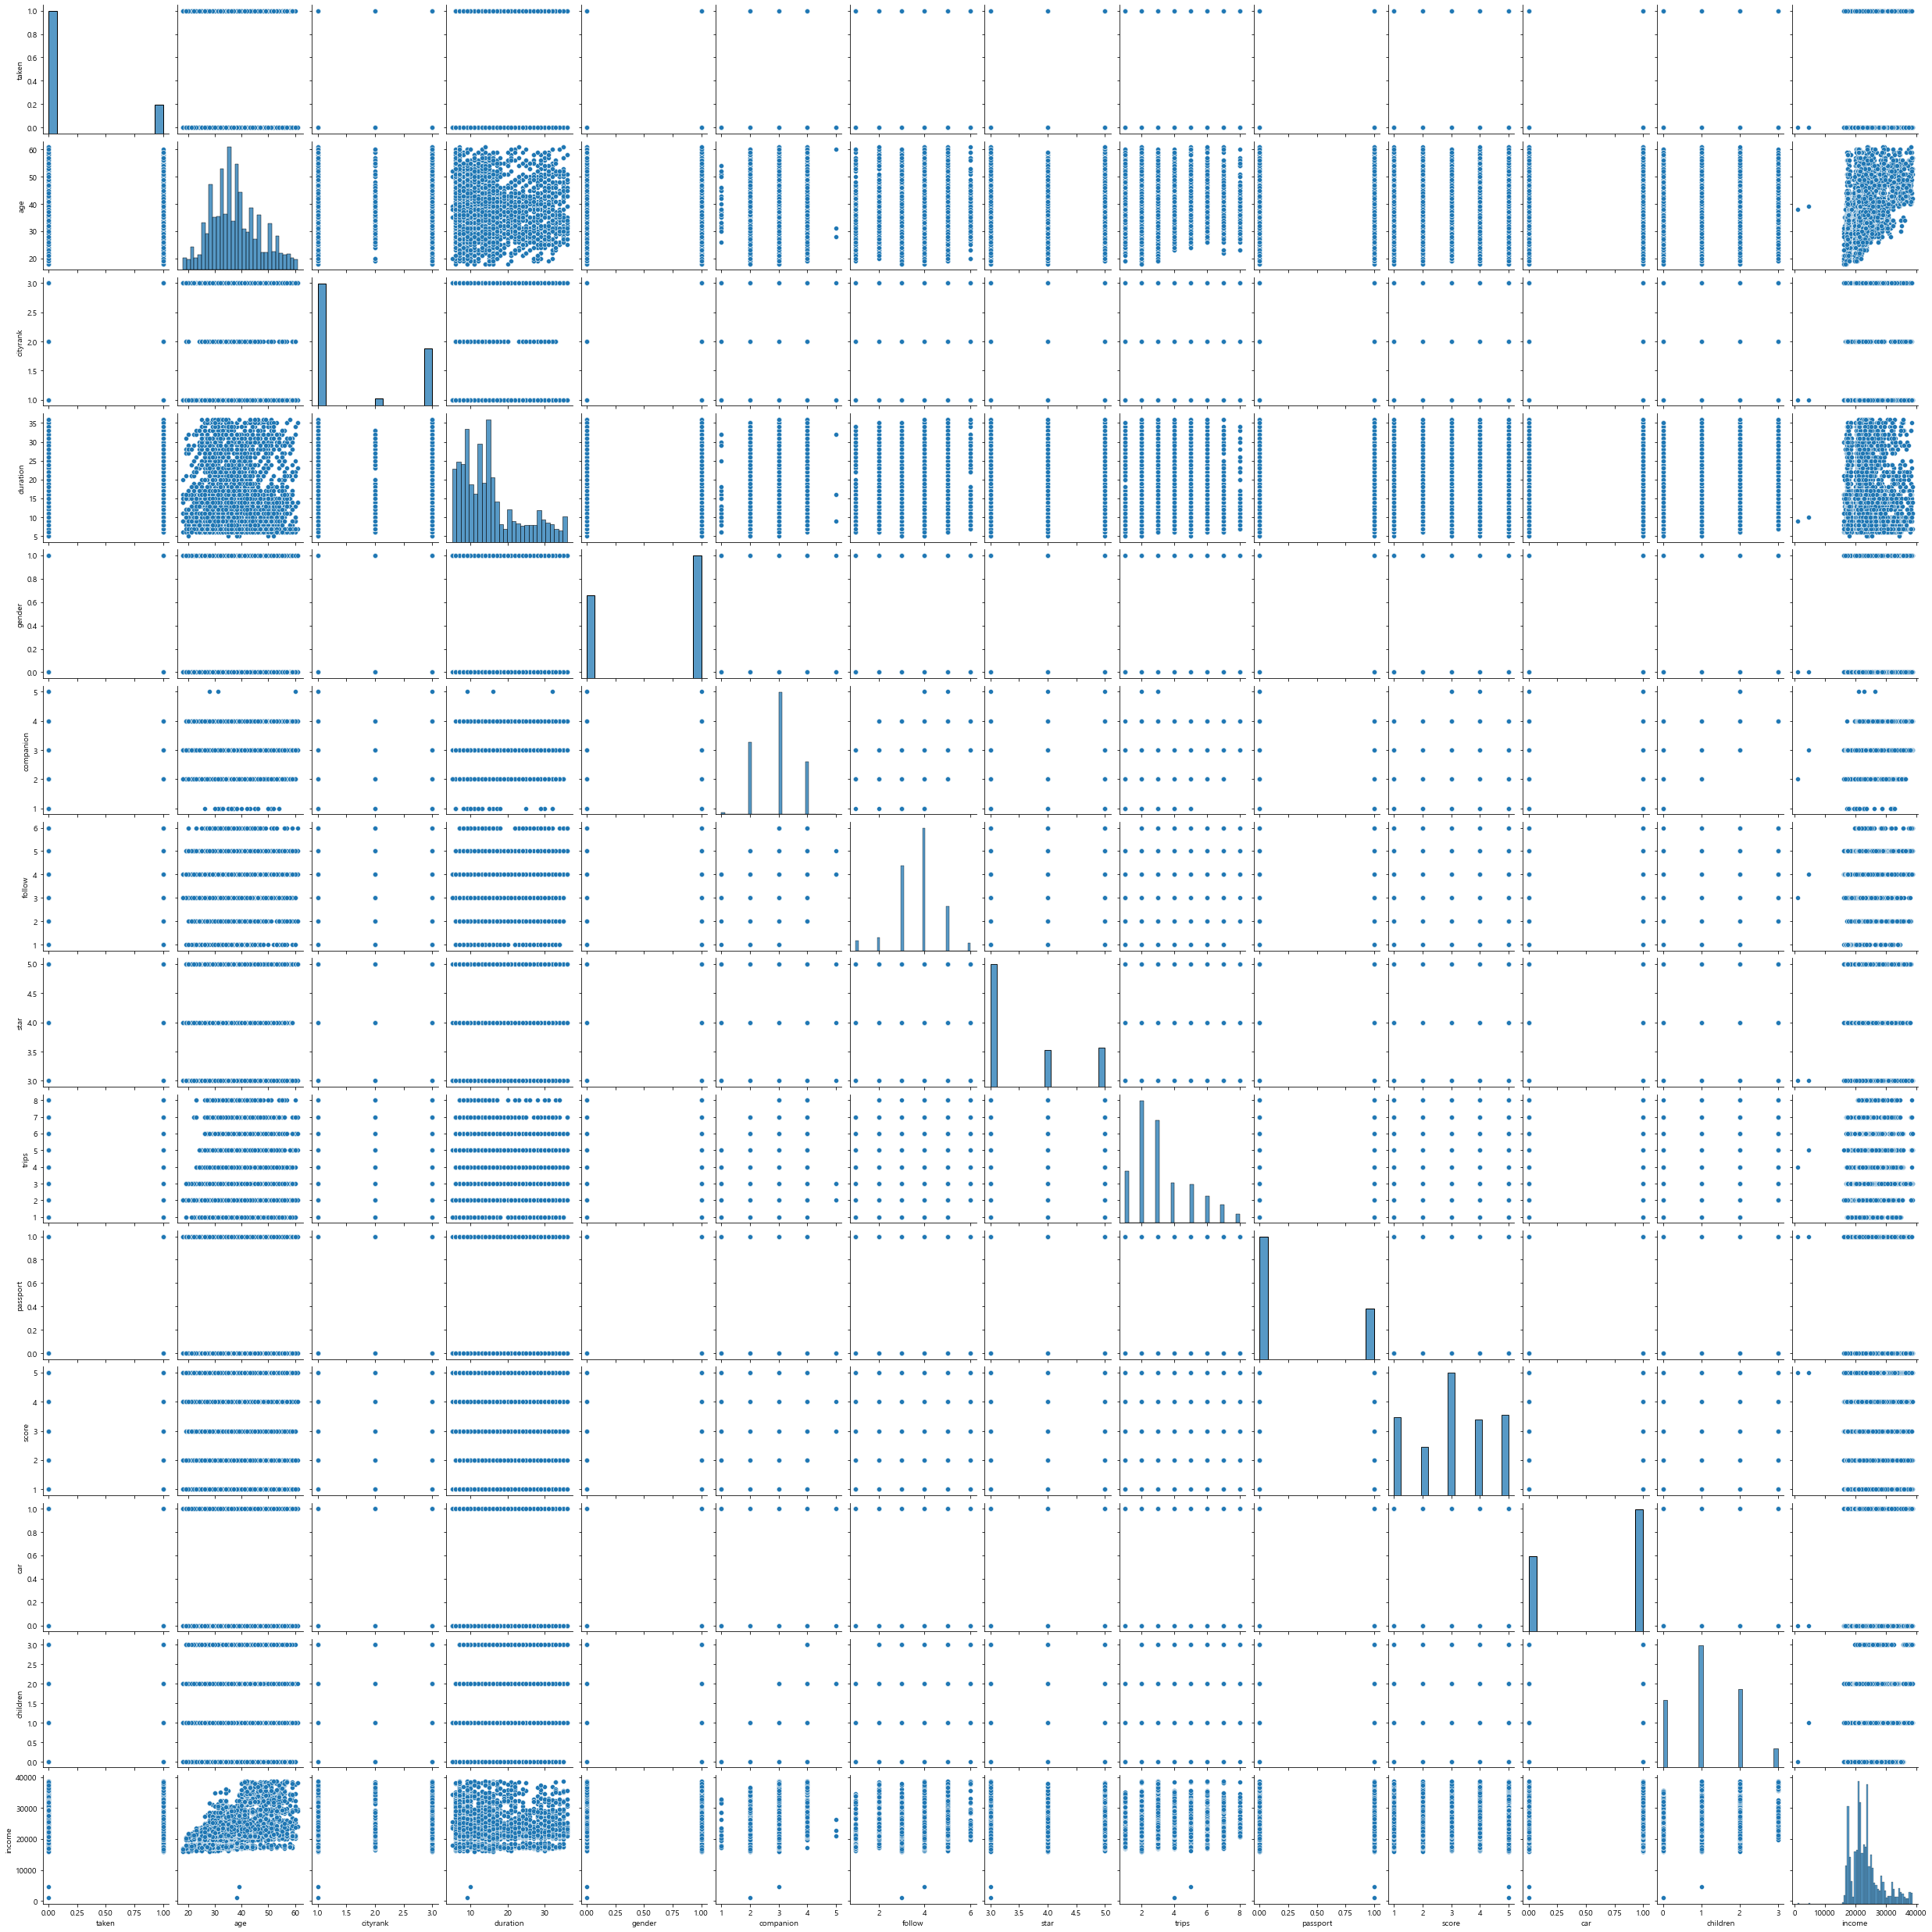

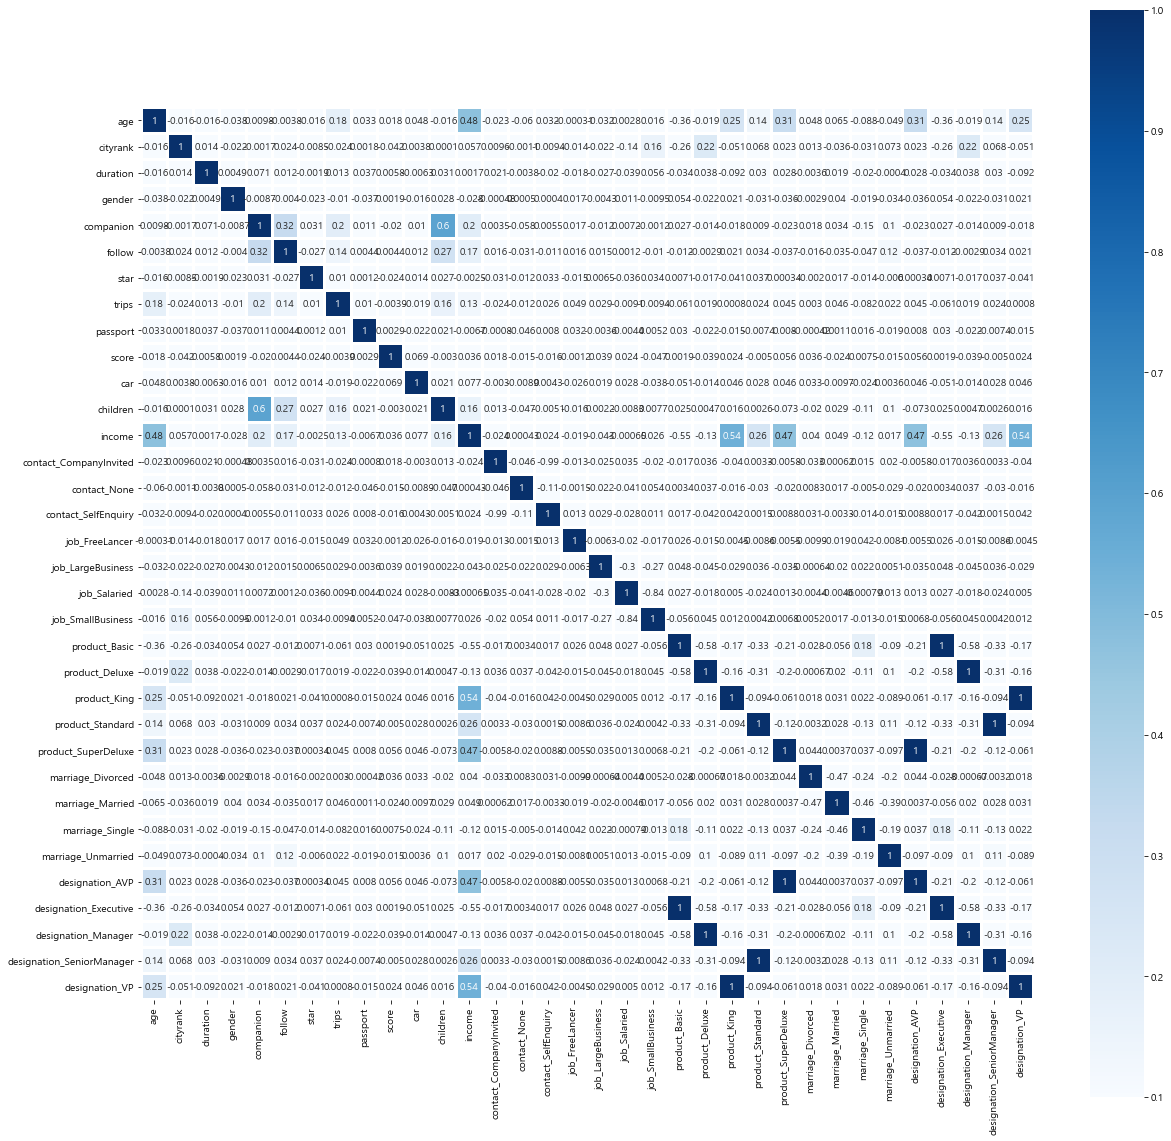

In [21]:
#시각화 부분 
import matplotlib.pyplot as plt
import seaborn as sns
#한글 폰트
from matplotlib import font_manager, rc
font = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font)
sns.pairplot(holiday)
corrmat = holiday_data.corr()
plt.subplots(figsize=(20,20))
sns.heatmap(corrmat, vmax=1.0, vmin=0.1,square=True,cmap='Blues',linewidths=2,annot=True)

<AxesSubplot:title={'center':'고객 직무별 캐키지 구매 그래프 '}, xlabel='product', ylabel='count'>

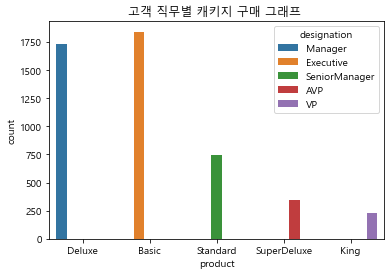

In [22]:
#범주형 그래프
plt.title("고객 직무별 캐키지 구매 그래프 ")
sns.countplot(data=holiday,x='product',hue='designation')

<AxesSubplot:title={'center':'고객 직무별 구매여부 그래프 '}, xlabel='designation', ylabel='count'>

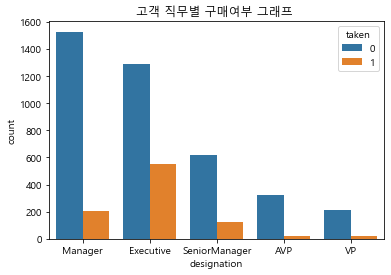

In [23]:
plt.title("고객 직무별 구매여부 그래프 ")
sns.countplot(data=holiday,x='designation',hue='taken')

<AxesSubplot:title={'center':'패키지 판매 및 유입경로 그래프'}, xlabel='product', ylabel='count'>

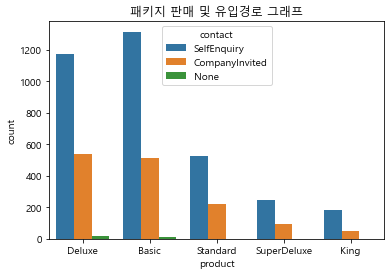

In [24]:
plt.title("패키지 판매 및 유입경로 그래프")
sns.countplot(data=holiday,x='product',hue='contact')

No handles with labels found to put in legend.


Text(0.5, 1.0, '직업별 패키지 판매 그래프')

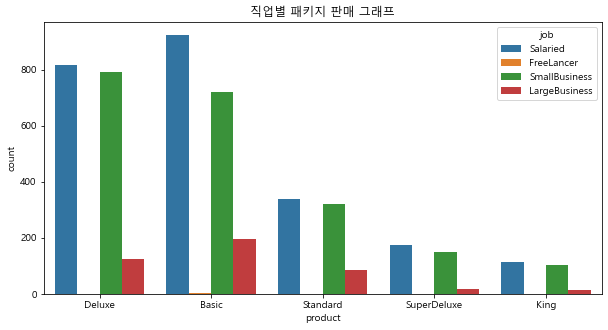

In [25]:
plt.figure(figsize=[10,5])
plt.legend(loc='right')
sns.countplot(data=holiday,x='product',hue='job')
plt.title("직업별 패키지 판매 그래프")


Text(0.5, 1.0, '직업별 수입 분포')

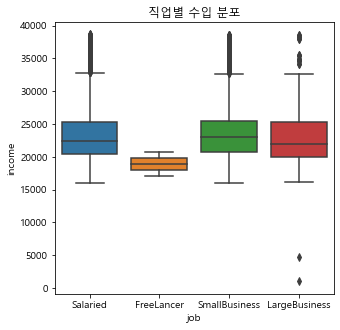

In [26]:
plt.figure(figsize=[5,5])
sns.boxplot(data=holiday,x='job',y='income')
plt.title("직업별 수입 분포")


Text(0.5, 1.0, '고객 수입과 직무 그래프')

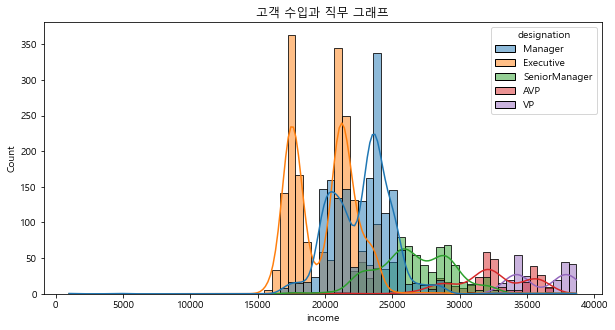

In [27]:
plt.figure(figsize=[10,5])
sns.histplot(data=holiday,x='income',hue='designation',kde=True)
plt.title('고객 수입과 직무 그래프')


Text(0.5, 1.0, '고객 수입과 직업 그래프')

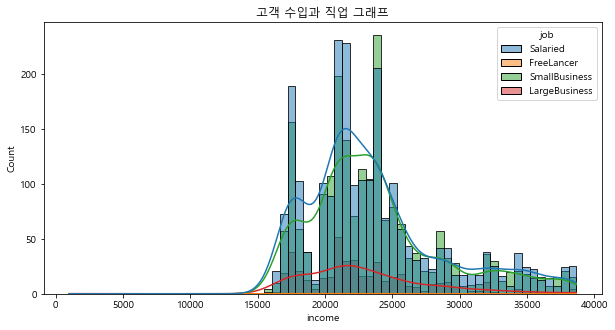

In [28]:
plt.figure(figsize=[10,5])
sns.histplot(data=holiday,x='income',hue='job',kde=True)
plt.title('고객 수입과 직업 그래프')

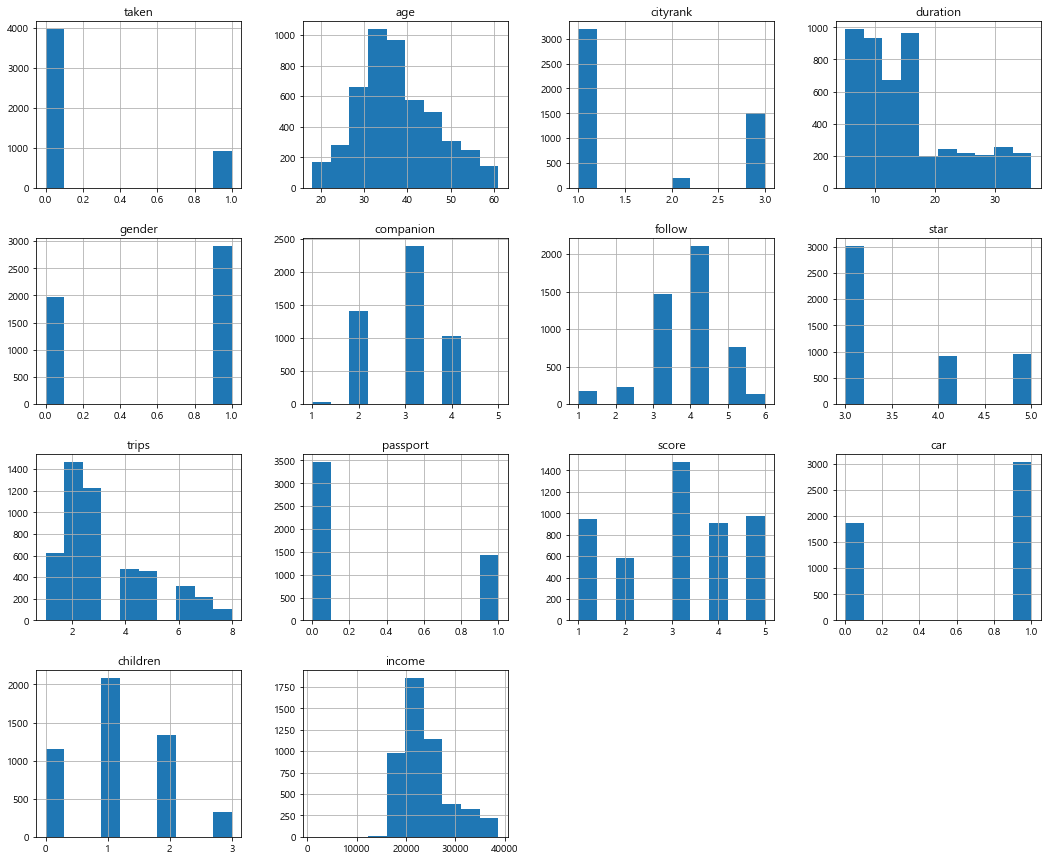

In [30]:
holiday.hist(figsize=(18,15))  
plt.show()


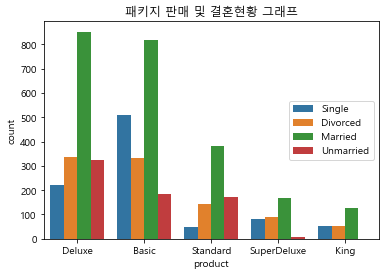

In [31]:
plt.title("패키지 판매 및 결혼현황 그래프")
sns.countplot(data=holiday,x='product',hue='marriage')
plt.legend(loc='right')


<AxesSubplot:title={'center':'도시등급 및 권유시간 분포'}, xlabel='duration', ylabel='Count'>

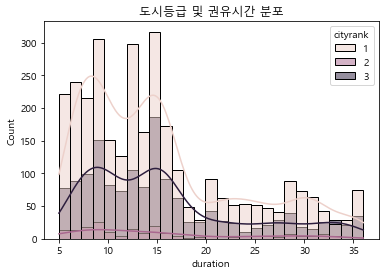

In [32]:
plt.title('도시등급 및 권유시간 분포')
sns.histplot(data=holiday2,x='duration',hue='cityrank',kde=True)


Text(0.5, 1.0, '고객 나이 및 구매여부 그래프')

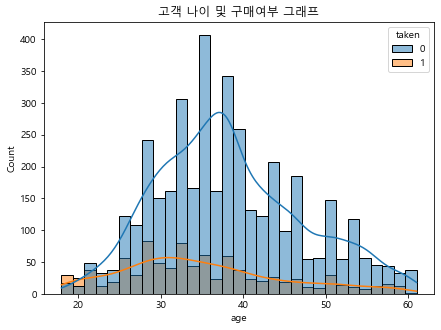

In [33]:
plt.figure(figsize=[7,5])
sns.histplot(data=holiday,x='age',hue='taken',kde=True)
plt.title('고객 나이 및 구매여부 그래프')


Text(0.5, 1.0, '고객 나이과 아동 동반자 그래프')

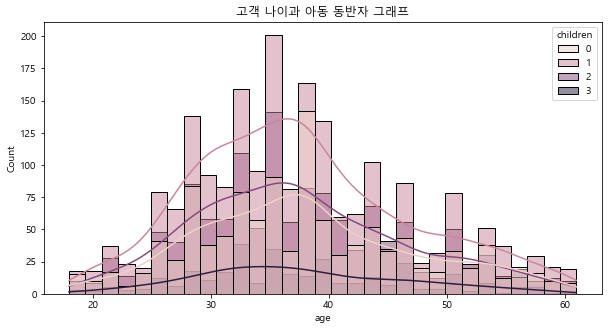

In [34]:
plt.figure(figsize=[10,5])
sns.histplot(data=holiday,x='age',hue='children',kde=True)
plt.title('고객 나이과 아동 동반자 그래프')


<AxesSubplot:title={'center':'고객 수입,결혼여부 및 구매여부 분포'}, xlabel='marriage', ylabel='income'>

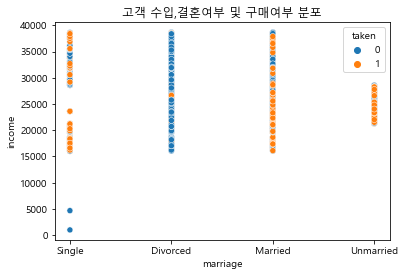

In [35]:
plt.title("고객 수입,결혼여부 및 구매여부 분포")
sns.scatterplot(data=holiday,x='marriage',y='income',hue='taken')

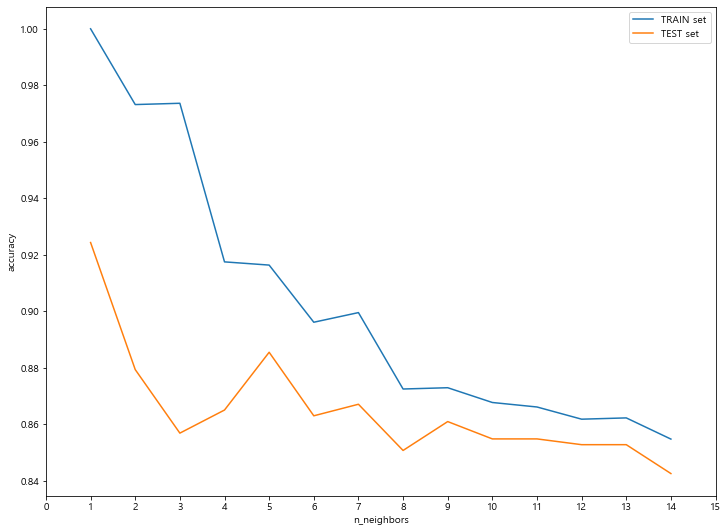

In [36]:
#하이퍼 파라미터 변도 및 정확율 그래프
train_acc = []
test_acc = []
for n in range(1,15):
    clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=n)
    clf.fit(x_train, y_train)
    prediction = clf.predict(x_test)
    train_acc.append(clf.score(x_train, y_train))
    test_acc.append((prediction==y_test).mean())
plt.figure(figsize=(12, 9))
plt.plot(range(1, 15), train_acc, label='TRAIN set')
plt.plot(range(1, 15), test_acc, label='TEST set')
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.xticks(np.arange(0, 16, step=1))
plt.legend()